In [1]:
from __future__ import unicode_literals,print_function,division

In [2]:
from io import open

In [3]:
import glob,os

In [4]:
def findFiles(path):
    return glob.glob(path)

In [5]:
print(findFiles('data/names/*.txt'))

['data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Chinese.txt', 'data/names/Arabic.txt', 'data/names/French.txt', 'data/names/Vietnamese.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Scottish.txt', 'data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Dutch.txt']


In [6]:
import unicodedata,string

In [7]:
all_letters = string.ascii_letters + ".,;'"

In [8]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'"

In [10]:
n_letters = len(all_letters)
n_letters

56

In [11]:
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD',s)
                  if unicodedata.category(c)!= 'Mn' and c in all_letters)

In [14]:
unicodeToAscii("hel$$lo/uxx")

'hellouxx'

In [15]:
category_lines = {}
all_categories = []

In [16]:
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [17]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [21]:
n_categories = len(all_categories)
n_categories

18

In [20]:
print(category_lines['English'][:10])

['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel', 'Abraham', 'Abrahams', 'Abrams', 'Ackary', 'Ackroyd']


In [22]:
#loading data done

In [23]:
import torch

def letterToIndex(char):
    return all_letters.find(char)

def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)] = 1 #one_hot encoding
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    for li,letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [24]:
print(letterToTensor('S'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])


In [28]:
print(lineToTensor("Sunny").size())

torch.Size([5, 1, 56])


In [29]:
# preprocessing done

In [30]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o = nn.Linear(input_size+hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)

In [31]:
n_hidden = 100
rnn = RNN(n_letters,n_hidden,n_categories)

In [32]:
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden)
out,next_hid = rnn(input,hidden)

In [33]:
print(out)

tensor([[-2.8561, -2.9228, -2.8783, -2.7746, -2.9820, -2.7900, -2.9315, -2.9132,
         -2.8927, -2.8779, -2.8130, -2.7625, -2.8838, -2.9582, -2.9857, -2.9358,
         -3.0129, -2.9010]], grad_fn=<LogSoftmaxBackward>)


In [36]:
def categoryFromOutput(output):
    top_n,top_i = output.topk(1)
    cat_i = top_i[0].item()
    return all_categories[cat_i],cat_i

In [37]:
categoryFromOutput(out)

('Italian', 11)

In [38]:
import random

def randomChoice(T):
    return T[random.randint(0,len(T)-1)]

def trainEx():
    cat = randomChoice(all_categories)
    line = randomChoice(category_lines[cat])
    cat_tensor = torch.tensor([all_categories.index(cat)],dtype = torch.long)
    line_tensor = lineToTensor(line)
    return cat,line,cat_tensor,line_tensor

In [40]:
for i in range(10):
    category, line, category_tensor, line_tensor = trainEx()
    print('category =', category, '/ line =', line)


category = Korean / line = Yeon
category = Greek / line = Papadopulos
category = Japanese / line = Ishibashi
category = Korean / line = Han
category = Spanish / line = Vargas
category = Scottish / line = Hill
category = Polish / line = Majewski
category = Vietnamese / line = Tong
category = Portuguese / line = Soares
category = Scottish / line = Duncan


In [41]:
criterion = nn.NLLLoss()

In [43]:
lr = 0.0005

def train(category_tensor,line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    
    loss = criterion(output,category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-lr,p.grad.data)
    
    return output,loss.item()

In [48]:
import math,time

n_iters = 100000
print_every = 5000
plot_every = 5000

current_loss = 0
all_losses=[]

def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s -= m*60
    
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1,n_iters+1):
    cat,line,cat_tensor,line_tensor = trainEx()
    output,loss = train(cat_tensor,line_tensor)
    current_loss += loss
    
    if iter%print_every == 0:
        print(current_loss)
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

        

14230.896446228027
14116.958337306976
13993.535258769989
13866.346113681793
13687.411993026733
13360.83719921112
12980.639163672924
12595.45652653277
12341.984222114086
12037.00873684138
11828.334574729204
11654.870216339827
11624.25974997878
11391.218497529626
11262.826533868909
11017.371139600873
10977.37425661087
10744.480130322278
10642.016796765849
10432.727720469236


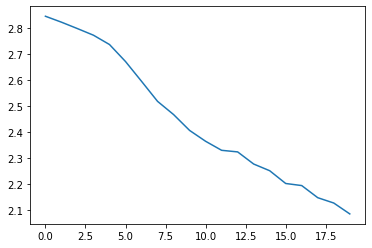

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [55]:
#training complete

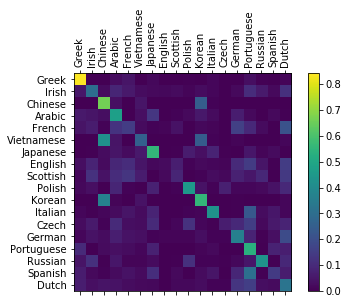

In [56]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = trainEx()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
